In [189]:
import os
%cd "C:\Users\lout0\OneDrive\Images\PROJETS OPENCLASSROOMS\P10_Talbi_Loutfi"

C:\Users\lout0\OneDrive\Images\PROJETS OPENCLASSROOMS\P10_Talbi_Loutfi


In [190]:
#Analyse, manipulation et visualisation de données sous forme de tableaux et de graphique.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#Visualisation avancées des données manquantes.
import missingno as mno

#Outils, tests statistiques et Machine Learning.

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from scipy.stats import t , shapiro

from itertools import combinations

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, accuracy_score 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.base import clone
from sklearn.svm import SVC



In [191]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## **Objectif de cette mission : Créer une programme capable de reconnaître avec précision les faux billets de banque parmis un séléction de données externes inconnues par l'algorithme**


### I - Importation, préparation et nettoyage des données.

In [192]:
billets = pd.read_csv("billets.csv", sep=';' , index_col=False, header=0)
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.810,104.860,104.950,4.520,2.890,112.830
1,True,171.460,103.360,103.660,3.770,2.990,113.090
2,True,172.690,104.480,103.500,4.400,2.940,113.160
3,True,171.360,103.910,103.940,3.620,3.010,113.510
4,True,171.730,104.280,103.460,4.040,3.480,112.540
...,...,...,...,...,...,...,...
1495,False,171.750,104.380,104.170,4.420,3.090,111.280
1496,False,172.190,104.630,104.440,5.270,3.370,110.970
1497,False,171.800,104.010,104.120,5.510,3.360,111.950
1498,False,172.060,104.280,104.060,5.170,3.460,112.250


#### Interprétation des variables à disposition :

1500 valeurs, 7 variables
* is_genuine (booléenne) : vérifie l'authenticité du billet au préalable (True = vrai billet, False = faux billet),
* length : longueur (en mm),
* height_left : hauteur - côté gauche (en mm),
* height_right : hauteur - côté droit (en mm),
* margin_up : marge haute - c'est la distance entre le bord du billet et la zone d'impression (en mm),
* margin_low : marge basse (en mm),
* diagonal : diagonale (en mm).

Vérifions désormais si ces données sont complètes :

In [193]:
tauxNA_billets = billets.isna().sum()/billets.shape[0]
tauxNA_billets

is_genuine     0.000
diagonal       0.000
height_left    0.000
height_right   0.000
margin_low     0.025
margin_up      0.000
length         0.000
dtype: float64

<AxesSubplot: >

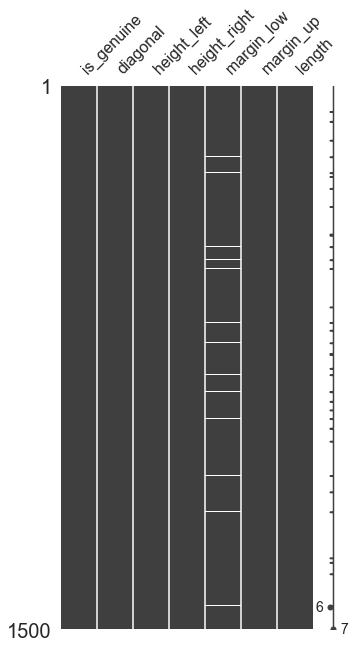

In [194]:
mno.matrix(billets, figsize = (5, 10))

*Nous constatons que 2,5% des données sont manquantes, et ce uniquement pour la variable margin_low (marge basse).
Nous ne pouvons pas créer un programme de détéction (basé sur la prédiction) avec un jeu de données incomplet.
Nous devons donc combler ces zones vides.
Pour combler ces zones vides, plusieurs approches sont possibles : 
* Supprimer les données manquantes (la plus simple)
* Les remplacer par des valeurs fixes comme la moyenne ou la médiane (la moins fiable)
* Les remplacer avec un arbre de décision (peu performant et risque de sur-apprentissage)
* Remplacer les NA par les valeurs les plus proches : c'est l'imputation par KNN (k plus proches voisins) (intérressante vu la taille du dataset)
* Imputation par regression linéaire (la plus pertinente)
* Méthode Hot-Deck : pêcher une valeur aléatoire existante et la recoller sur une valeur nulle au hasard. (trop aléatoire)


Vu la taille du jeu de données, mieux vaut s'adonner à une approche comme le KNN ou la regression linéaire multiple. Je choisis personnellement la regression linéaire multiple.


In [195]:
#Séparation des NAs sur un nouveau dataset.

NA_data=billets[billets.isnull().any(axis=1)]
NA_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     bool   
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    0 non-null      float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: bool(1), float64(6)
memory usage: 2.1 KB


In [196]:
#Analyse de la corrélation

corr_billets = billets.dropna(inplace=False)
corr_billets.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000,0.135,-0.374,-0.487,-0.783,-0.610,0.850
diagonal,0.135,1.000,0.018,-0.019,-0.112,-0.059,0.101
height_left,-0.374,0.018,1.000,0.235,0.303,0.244,-0.314
height_right,-0.487,-0.019,0.235,1.000,0.391,0.307,-0.404
margin_low,-0.783,-0.112,0.303,0.391,1.000,0.432,-0.667
margin_up,-0.610,-0.059,0.244,0.307,0.432,1.000,-0.521
length,0.850,0.101,-0.314,-0.404,-0.667,-0.521,1.000


In [197]:
billets1 = billets.drop(columns='is_genuine')
billets1_train = billets1.dropna()
billets1_test = billets1.loc[billets1['margin_low'].isnull(),:]

In [198]:
#Matrice de corrélation.

def correlation_matrix(df):
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    sns.heatmap(df.corr(), mask=mask, cmap='coolwarm',  annot=True, vmin=-1, vmax=1, fmt = '.2f')
    plt.show()

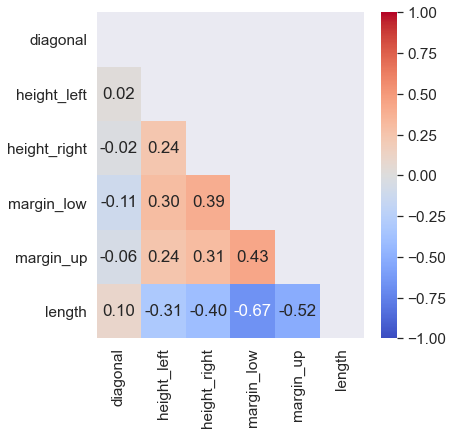

In [199]:
correlation_matrix(corr_billets.iloc[:,1:7])

**Nous constatons que les variables ne sont que très peu correlées entre elles voire anti-correlées. De plus nous pouvons voir ci-dessous que les relations entre ces variables ne sont pas parfaitement linéaire mais le tracé d'une droite est envisageable. Continuons dans cette lancée bien qu'une imputation par KNN aurait été tout autant interressante.

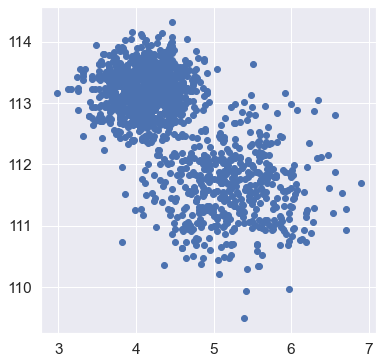

In [200]:
plt.scatter(x=billets1_train['margin_low'], y= billets1_train['length'])

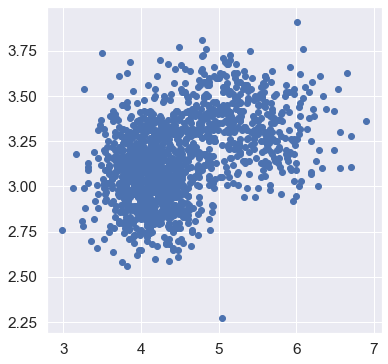

In [201]:
plt.scatter(x=billets1_train['margin_low'], y= billets1_train['margin_up'])

In [202]:
y = billets1_train['margin_low']
X = billets1_train[['margin_up', 'length']]

In [203]:
regressor = LinearRegression()
regressor.fit(X,y)
y_pred = regressor.predict(X)

In [204]:
#projection en 3D des trois variables précedente.

%matplotlib qt 
fig = plt.figure(figsize=(16, 12))
ax= plt.axes(projection='3d')

ax.scatter(billets1_train['margin_up'], billets1_train['length'], billets1_train['margin_low'], c = "r", marker = 'o')
ax.set_xlabel('margin_up')
ax.set_ylabel('length')
ax.set_zlabel('margin_low')
ax.plot_trisurf(billets1_train["margin_up"], billets1_train["length"], y_pred)
ax

<Axes3DSubplot: xlabel='margin_up', ylabel='length', zlabel='margin_low'>

Relation linéaire entre les variables indépendantes et la variable dépendante : la variation de la variable dépendante pour chaque augmentation d’une unité d’une variable indépendante suit une ligne droite. (c'est ce que l'on prétend plus ou moins sur ces graphiques.

In [205]:

res = smf.ols('margin_low ~ diagonal + height_left + height_right + margin_up + length', data = billets1_train).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 01 Dec 2022   Prob (F-statistic):          2.60e-202
Time:                        16:30:37   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Coéfficient de détermination à 0,477. C'est une indicateur permettant de mettre en évidence que, dans cette situation, la regression linéaire n'est ni l'outil idéal, ni à exclure. Plus le R2 est proche de 1, plus la régression linéaire est en adéquation avec les données collectées. 
Les p-valeurs étant toutes inferieures à 0.05 , nous pouvons conserver toutes les variables.
Differentes donnéess ne sont pas à prendre en compte comme le Jarque-Bera qui n'est pas fiable, dans ce contexte.


Nous confirmons l'idée qu'une approche par KNN  **AURAIT** été peut être plus judicieux. Continuons malgré tout dans cette lancée.

In [206]:
resid = billets1_train.copy()

In [207]:
resid['residus'] = res.resid

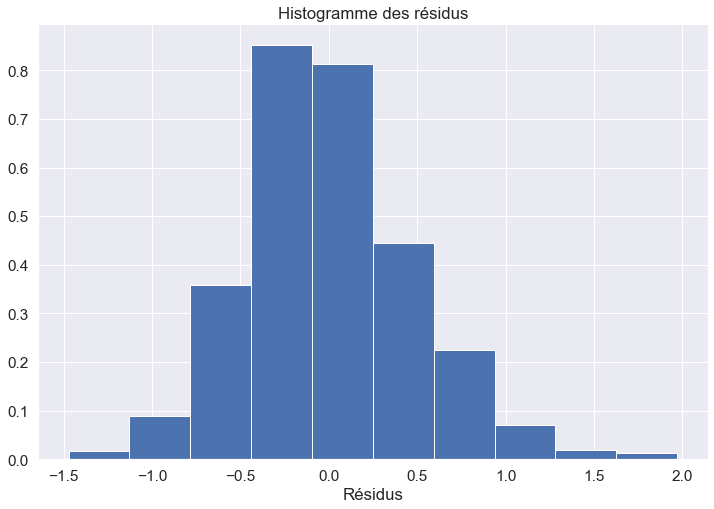

In [208]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,8))
plt.hist(resid['residus'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

Distribution normale des résiduels : bien que les variables indépendantes ne doivent pas nécessairement suivre une distribution normale, il importe que les résiduels en suivent une. Ils doivent donc avoir une moyenne de 0, la majorité des valeurs doivent s’en rapprocher. Cette prémisse peut être vérifiée en enregistrant les valeurs résiduelles dans la base de données et en effectuant le test de Kolmogorov-Smirnov ou de Shapiro-Wilks

In [209]:
shapiro(res.resid) #test de normalité

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

L'hypothèse étant rejetée, le test n'est pas considéré comme gaussien  : Il ne faut pas tomber dans le piège et prendre au mot ces résultats : Nous ne sommes pas sur une distribution normale parfaite, mais on s'en rapproche et c'est au final très positif.

In [210]:
#colinéarité

values = res.model.exog
[variance_inflation_factor(values, i) for i in np.arange(1,values.shape[1])]

[1.0136128990686282,
 1.1382605736082494,
 1.2301145155560378,
 1.4044037781843617,
 1.5769501453665788]

Aucune multicolinéarité parfaite : il ne doit pas y avoir de relation linéaire parfaite entre deux ou plusieurs variables indépendantes. Par conséquent, les corrélations ne doivent pas être trop fortes entre celles-ci. Cette prémisse peut être vérifiée avec le VIF (Variance Inflation Factor) indiquant si une variable indépendante a une une relation linéaire forte avec les autres. La règle arbitraire souvent appliquée veut qu’une valeur de cet indice plus grande que 10 indique la présence d’un tel problème. Ici toutes les valeurs sont inferieures à 10, cela traduit l'absence verifiée de colinéarité.

In [211]:
#homoscédasticité, constance de variance dans le temps


white = het_white(res.resid,  res.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'p-value']

#print results of White's test
print(dict(zip(labels, white)))

{'Test Statistic': 109.86015196912189, 'p-value': 2.0828244985772627e-14}


Homoscédasticité (constance des variances des résiduels) : la variance des valeurs résiduelles n'est pas constante.
En effet, toutes les variables ne partagent pas les mêmes résultats, en témoignent ce graphique, ci-dessous, bien qu'on s'en rapproche (encore une fois...)

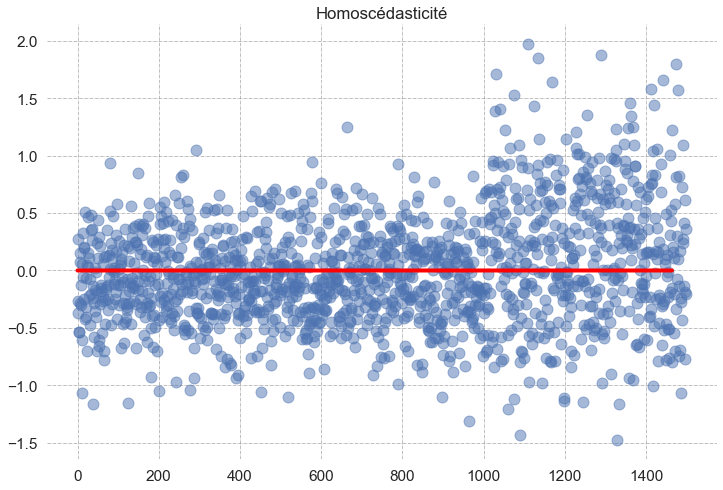

In [212]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_title("Homoscédasticité")
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
plt.scatter(x = billets1_train.index, y = resid["residus"], s= 120 , alpha=0.5)
plt.plot(np.repeat(0, len(billets1_train.index)+2),linewidth=4, color="red", linestyle='-')
plt.show()

In [213]:
X= billets1_train[billets1_train.columns].values
y = billets1_train['margin_low'].values

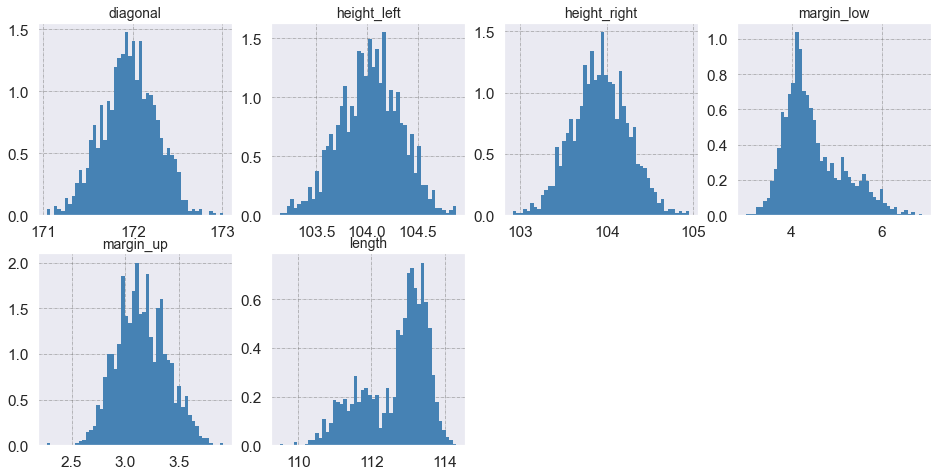

In [214]:
#normalité
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
    ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
    ax.set_title(billets1_train.columns[feat_idx], fontsize=14)


Au meme titre que les résultats précédents, la distribution des valeurs pour chaque variable est plus ou moins gaussienne, mais pas totalement. De plus nous constatons une bonne disparité pour certaine variable comme la longueur (length) ou la marge basse (margin_low), ce qui expliquerait certaine partie
Passons sans plus tarder à la prédiction des valeurs manquantes afin d'avoir le verdict.

In [215]:
X_nan = NA_data.drop(['margin_low'], axis=1)

In [216]:
pred_nan = res.predict(X_nan)

In [217]:
#dataset des valeurs nulles remplacées par la prédiction par regression linéaire multiple.

X_nan['margin_low'] = pred_nan
X_nan.head(50)

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.940,103.890,103.450,3.250,112.790,4.319
99,True,171.930,104.070,104.180,3.140,113.080,4.394
151,True,172.070,103.800,104.380,3.020,112.930,4.410
197,True,171.450,103.660,103.800,3.620,113.270,4.319
241,True,171.830,104.140,104.060,3.020,112.360,4.651
251,True,171.800,103.260,102.820,2.950,113.220,3.803
284,True,171.920,103.830,103.760,3.230,113.290,4.180
334,True,171.850,103.700,103.960,3.000,113.360,4.127
410,True,172.560,103.720,103.510,3.120,112.950,4.135
413,True,172.300,103.660,103.500,3.160,112.950,4.161


In [218]:
order = ['diagonal','height_left','height_right','margin_low','margin_up','length']
X_nan = X_nan[order]
X_nan.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
72,171.940,103.890,103.450,4.319,3.250,112.790
99,171.930,104.070,104.180,4.394,3.140,113.080
151,172.070,103.800,104.380,4.410,3.020,112.930
197,171.450,103.660,103.800,4.319,3.620,113.270
241,171.830,104.140,104.060,4.651,3.020,112.360


In [223]:
billets1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1463 non-null   float64
 1   height_left   1463 non-null   float64
 2   height_right  1463 non-null   float64
 3   margin_low    1463 non-null   float64
 4   margin_up     1463 non-null   float64
 5   length        1463 non-null   float64
dtypes: float64(6)
memory usage: 80.0 KB


In [224]:
billets_sans_nan = pd.concat([billets1_train, X_nan])

In [225]:
billets_sans_nan

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.810,104.860,104.950,4.520,2.890,112.830
1,171.460,103.360,103.660,3.770,2.990,113.090
2,172.690,104.480,103.500,4.400,2.940,113.160
3,171.360,103.910,103.940,3.620,3.010,113.510
4,171.730,104.280,103.460,4.040,3.480,112.540
...,...,...,...,...,...,...
1303,172.170,104.490,103.760,5.048,2.930,111.210
1315,172.080,104.150,104.170,4.779,3.400,112.290
1347,171.720,104.460,104.120,5.727,3.610,110.310
1435,172.660,104.330,104.410,5.186,3.560,111.470


In [226]:

billets_final = billets_sans_nan.copy()
billets_final['is_genuine'] = billets['is_genuine']
billets_final

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,171.810,104.860,104.950,4.520,2.890,112.830,True
1,171.460,103.360,103.660,3.770,2.990,113.090,True
2,172.690,104.480,103.500,4.400,2.940,113.160,True
3,171.360,103.910,103.940,3.620,3.010,113.510,True
4,171.730,104.280,103.460,4.040,3.480,112.540,True
...,...,...,...,...,...,...,...
1303,172.170,104.490,103.760,5.048,2.930,111.210,False
1315,172.080,104.150,104.170,4.779,3.400,112.290,False
1347,171.720,104.460,104.120,5.727,3.610,110.310,False
1435,172.660,104.330,104.410,5.186,3.560,111.470,False


**Voici le dataset final (billets_final) ou toutes les entrées sont complétées. Il faudra désormais réaliser des test de significativité pour savoir si notre approche a été suffisamment intérressante pour poursuivre sur l'analyse.**


In [227]:
billets_final['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [228]:
X= billets_final.loc[:, billets_final.columns != 'is_genuine'].values
y = billets_final['margin_low'].values

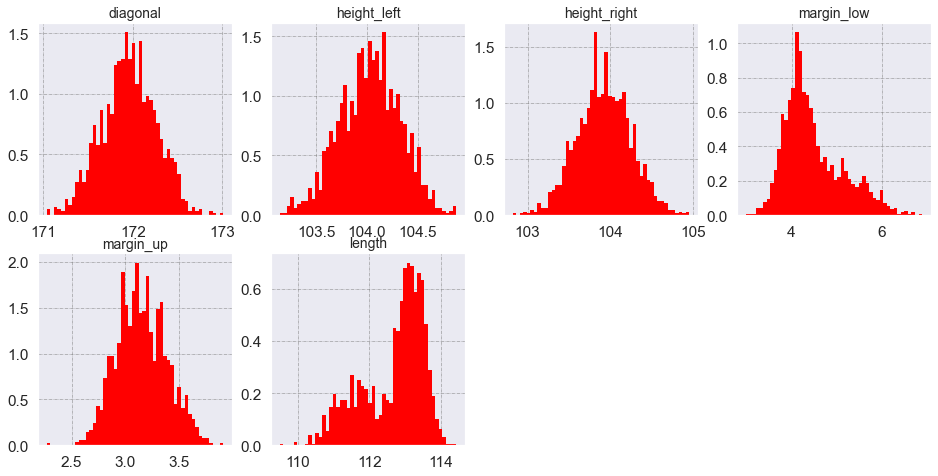

In [229]:
#normalité
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
    ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
    h = ax.hist(X[:, feat_idx], bins=50, color='red', density=True, edgecolor='none')
    ax.set_title(billets_final.columns[feat_idx], fontsize=14)

On voit ici que l'imputation par regression a modifié la densité, plus particulièrement pour la variable 'height_right' sans pour autant tout perturber.

In [230]:
for i in billets_final.iloc[:,:]:
    stat, pvalue = stats.shapiro(billets_final[i])
    print(pvalue)
    
    if pvalue > 0.05:
        print('Loi normale')
    else:
        print('pas de normalité')

0.323654443025589
Loi normale
0.051517147570848465
Loi normale
0.9806451797485352
Loi normale
1.2788993273920413e-24
pas de normalité
0.000814208120573312
pas de normalité
7.865591300479774e-28
pas de normalité
0.0
pas de normalité


Dans l'ordre du graphique :  is_genuine (booléenne) :
* diagonal : 0.32 **Loi normale**
* height_left : 0.052 **Loi normale**
* height_right : 0.98 **Loi normale**
* margin_low : 0.0008 **pas de normalité**
* margin_up : < 0.001 **pas de normalité**
* length : < 0.001 **pas de normalité**

In [231]:
billets_final.groupby("is_genuine").mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.901,104.190,104.144,5.214,3.350,111.631
True,171.987,103.949,103.809,4.118,3.052,113.202


<AxesSubplot: ylabel='is_genuine'>

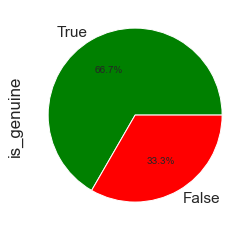

In [232]:
colors = ( "green", "red")
billets["is_genuine"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors )

<AxesSubplot: ylabel='is_genuine'>

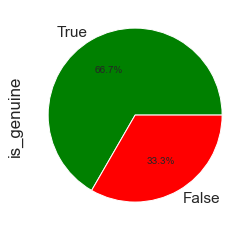

In [233]:
colors = ( "green", "red")
billets_final["is_genuine"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors )

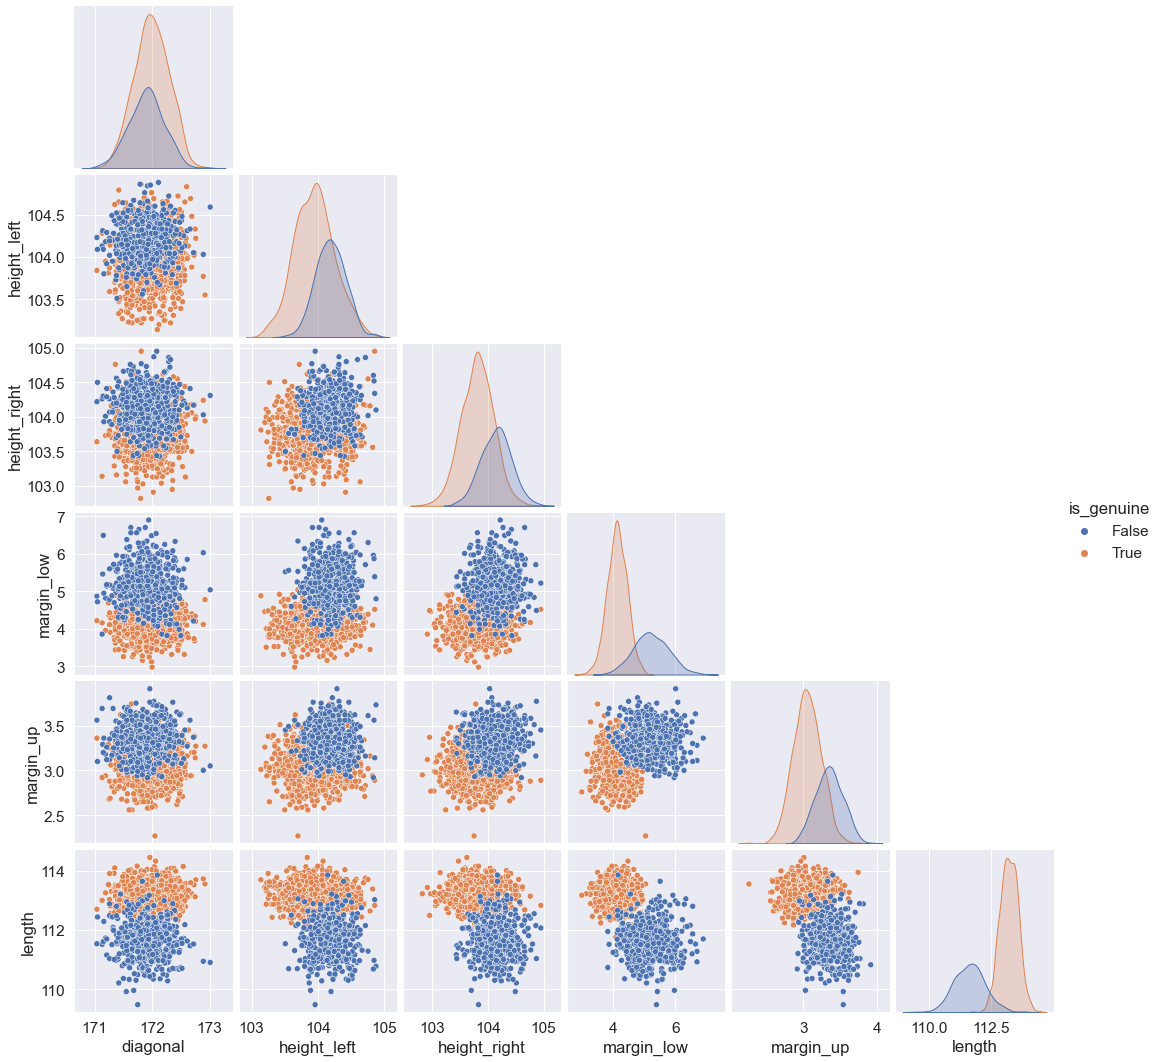

In [234]:
sns.pairplot(billets, hue='is_genuine', corner=True)
plt.show()

In [235]:
long_vrai = billets_final[billets_final.is_genuine == True].length
long_faux = billets_final[billets_final.is_genuine == False].length
f_value, p_value = stats.f_oneway(long_vrai,long_faux)
print(f_value,p_value)

3876.6541378261672 0.0


avec un risque alpha à 5% : p_value < 0.05, nous rejetons l’hypothèse nulle, donc les moyennes de 'length' des vrais billets et faux billets ne sont pas égaux.

In [236]:
mlow_vrai = billets_final[billets_final.is_genuine == True].margin_low
mlow_faux = billets_final[billets_final.is_genuine == False].margin_low
f_value, p_value = stats.f_oneway(mlow_vrai,mlow_faux)
print(f_value,p_value)

2380.7232707657054 8.919896249647e-312


avec un risque alpha à 5% : p_value < 0.05, nous rejetons l’hypothèse nulle, donc les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux.

### *CONCLUSION : Avec du recul, il semblerait que l'imputation par regression n'était pas aussi utile que cela. Une simple suppression des données manquantes aurait pu être envisageable ou à la limite remplacement par la moyene, puisqu'une imputation par KNN aurait été tout aussi inutlie ; En effet, le jeu de données est beaucoup trop petit pour mettre en évidence que telle ou telle approche serait plus interressante à mettre en place qu'une autre. Nous allons tout de même continuer avec ce dataset final.*

# Analyse en composante principale (ACP)

In [237]:
XX = billets_final.drop(columns= ['is_genuine'])
XX.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.810,104.860,104.950,4.520,2.890,112.830
1,171.460,103.360,103.660,3.770,2.990,113.090
2,172.690,104.480,103.500,4.400,2.940,113.160
3,171.360,103.910,103.940,3.620,3.010,113.510
4,171.730,104.280,103.460,4.040,3.480,112.540


In [238]:
#Centrage et réduction des données.

scaler = StandardScaler()
XX_scaled = scaler.fit_transform(XX)
XX_scaled

array([[-0.48653957,  2.77412327,  3.16324041,  0.0553898 , -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08198744, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12659056, -0.91256208,
         0.55190114],
       ...,
       [-0.78153123,  1.43794766,  0.61346228,  1.88579829,  1.97866106,
        -2.71480344],
       [ 2.29949275,  1.00369058,  1.50434862,  1.06517171,  1.76289814,
        -1.38519737],
       [-0.19154792,  0.83666863,  1.135706  ,  0.99568639,  0.38201544,
        -1.36227312]])

In [239]:
# Nombre de composantes souhaitées
n_components = 6

# Calcul des composantes principales
pca = PCA(n_components=n_components)
pca.fit(XX_scaled)

PCA(n_components=6)

In [240]:
variance = pd.DataFrame()
variance['expliquée(%)'] = 100*pca.explained_variance_ratio_
variance['cumulée(%)'] = 100*(pca.explained_variance_ratio_.cumsum())
variance

,expliquée(%),cumulée(%)
0,43.288,43.288
1,16.957,60.245
2,13.025,73.270
3,11.825,85.095
4,9.603,94.698
5,5.302,100.000


In [241]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker= 'x')
    plt.xlabel("Rang axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")

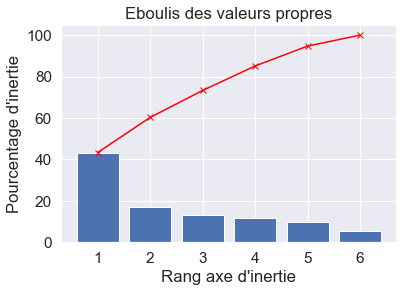

In [242]:
display_scree_plot(pca)
plt.show()

L'eboulis des valeurs propres est un outil d'aide à la décision quant au choix du nombre de dimensions à étudier. Ici, je choisis personnellement 2 dimensions qui representent à elles seules plus de 60% de l'information. Nous allons dont étudier F1 et F2.

In [243]:
XX_scaled

array([[-0.48653957,  2.77412327,  3.16324041,  0.0553898 , -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08198744, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12659056, -0.91256208,
         0.55190114],
       ...,
       [-0.78153123,  1.43794766,  0.61346228,  1.88579829,  1.97866106,
        -2.71480344],
       [ 2.29949275,  1.00369058,  1.50434862,  1.06517171,  1.76289814,
        -1.38519737],
       [-0.19154792,  0.83666863,  1.135706  ,  0.99568639,  0.38201544,
        -1.36227312]])

In [244]:
XX_pc = pd.DataFrame()

In [245]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_components = 6

# Calcul des composantes principales
pca = PCA(n_components=n_components)

reduced = pca.fit_transform(XX_scaled)
# Append the principle components for each entry to the dataframe
for i in range(0, n_components):
    XX_pc['F' + str(i + 1)] = reduced[:, i]

display(XX_pc.head())

,F1,F2,F3,F4,F5,F6
0,1.644,0.748,2.403,3.181,0.304,-0.012
1,-2.020,-2.207,-1.002,0.073,0.033,-0.476
2,-0.970,2.620,1.195,-0.924,-0.838,0.207
3,-1.377,-1.818,0.651,0.828,0.800,-0.231
4,0.149,-0.567,0.854,-1.788,1.178,-0.303


In [246]:
XX_pc['is_genuine'] = billets_final['is_genuine']
XX_pc

,F1,F2,F3,F4,F5,F6,is_genuine
0,1.644,0.748,2.403,3.181,0.304,-0.012,True
1,-2.020,-2.207,-1.002,0.073,0.033,-0.476,True
2,-0.970,2.620,1.195,-0.924,-0.838,0.207,True
3,-1.377,-1.818,0.651,0.828,0.800,-0.231,True
4,0.149,-0.567,0.854,-1.788,1.178,-0.303,True
...,...,...,...,...,...,...,...
1495,1.158,0.933,1.156,-0.522,-1.723,-0.882,False
1496,1.335,0.522,-0.289,0.010,0.549,0.138,False
1497,4.041,-0.505,0.252,-0.985,-0.112,-0.516,False
1498,2.775,2.483,-0.818,-0.102,0.417,-0.043,False


In [247]:
billets_final

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,171.810,104.860,104.950,4.520,2.890,112.830,True
1,171.460,103.360,103.660,3.770,2.990,113.090,True
2,172.690,104.480,103.500,4.400,2.940,113.160,True
3,171.360,103.910,103.940,3.620,3.010,113.510,True
4,171.730,104.280,103.460,4.040,3.480,112.540,True
...,...,...,...,...,...,...,...
1303,172.170,104.490,103.760,5.048,2.930,111.210,False
1315,172.080,104.150,104.170,4.779,3.400,112.290,False
1347,171.720,104.460,104.120,5.727,3.610,110.310,False
1435,172.660,104.330,104.410,5.186,3.560,111.470,False


C:\Users\lout0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


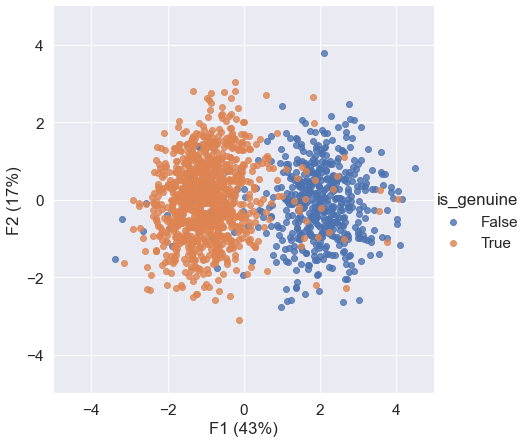

In [248]:
g = sns.lmplot('F1',
               'F2',
               hue='is_genuine',data=XX_pc,
               fit_reg=False,
               scatter=True,
               height=6)
plt.xlabel('F1 ({}%)'.format(
    round(100*pca.explained_variance_ratio_[0]) ,2))
plt.ylabel('F2 ({}%)'.format(
    round(100*pca.explained_variance_ratio_[1]) ,2))
plt.xlim([-5,5])
plt.ylim([-5,5])

plt.show()

La projection sur plan factoriel montre une disparité importante entre les faux et les vrais billets bien que l'on retrouve des exceptions dans chaque nuage.

In [249]:


dictionary = {'F1': 'diagonal','F2': 'height_left','F3': 'height_right','F4': 'margin_low', 'F5' : 'margin_up','F6': 'length'}
XX_pc.rename(columns=dictionary, inplace=True)

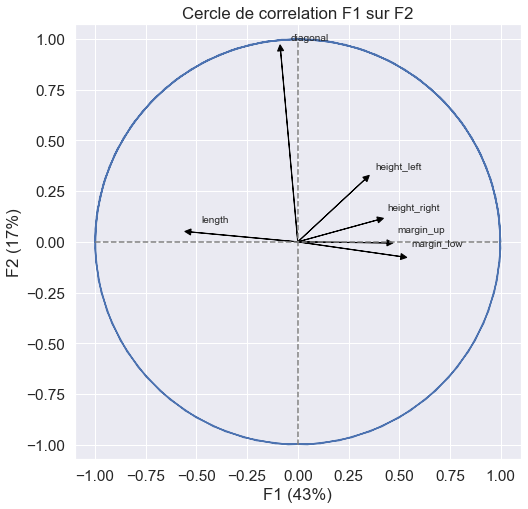

In [250]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.03,
             head_length=0.03, color= 'black')

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             XX_pc.columns.values[i])


an = np.linspace(0, 5 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')
plt.xlabel('F1 ({}%)'.format(
    round(100*pca.explained_variance_ratio_[0]) ,2))
plt.ylabel('F2 ({}%)'.format(
    round(100*pca.explained_variance_ratio_[1]) ,2))
plt.axis('equal')
ax.set_title('Cercle de correlation F1 sur F2')
plt.show()

Le cercle de correlation ci-dessous representant F& et F2 ne donne des indications sur le rapport de correlation entre les variables : 

* Les variables les plus corrélées *positivement* à **F1** sont la hauteur et la marge,
* La variables les plus corrélée *négativement* à **F1** est la longueur,
* La variables les plus corrélée *positivement* à **F2** est la diagonale.

## Prédiction par l'agorithme K-means

**Rappel : K-means (k-moyennes) est un  algorithme non supervisé  de clustering. Il permet de regrouper en K clusters distincts les observations du data set. Ainsi les données similaires se retrouveront  dans un même cluster. Par ailleurs, une observation ne peut se retrouver que dans un cluster à la fois (exclusivité d’appartenance). Une même observation, ne pourra donc, appartenir à deux clusters différents.**

In [251]:
n_clusters = 2

In [252]:
kmeans = KMeans(init='random', n_clusters=2, n_init=10)

In [253]:
kmeans.fit(XX_scaled)

KMeans(init='random', n_clusters=2)

In [254]:
kmeans_df = billets_final.copy()

In [255]:
kmeans_df['Cluster'] = kmeans.labels_

In [256]:
kmeans_df

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,Cluster
0,171.810,104.860,104.950,4.520,2.890,112.830,True,1
1,171.460,103.360,103.660,3.770,2.990,113.090,True,0
2,172.690,104.480,103.500,4.400,2.940,113.160,True,0
3,171.360,103.910,103.940,3.620,3.010,113.510,True,0
4,171.730,104.280,103.460,4.040,3.480,112.540,True,0
...,...,...,...,...,...,...,...,...
1303,172.170,104.490,103.760,5.048,2.930,111.210,False,1
1315,172.080,104.150,104.170,4.779,3.400,112.290,False,1
1347,171.720,104.460,104.120,5.727,3.610,110.310,False,1
1435,172.660,104.330,104.410,5.186,3.560,111.470,False,1


In [257]:
for i in range(0, n_components):
    kmeans_df['F' + str(i + 1)] = reduced[:, i]

display(kmeans_df.head())

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,Cluster,F1,F2,F3,F4,F5,F6
0,171.810,104.860,104.950,4.520,2.890,112.830,True,1,1.644,0.748,2.403,3.181,0.304,-0.012
1,171.460,103.360,103.660,3.770,2.990,113.090,True,0,-2.020,-2.207,-1.002,0.073,0.033,-0.476
2,172.690,104.480,103.500,4.400,2.940,113.160,True,0,-0.970,2.620,1.195,-0.924,-0.838,0.207
3,171.360,103.910,103.940,3.620,3.010,113.510,True,0,-1.377,-1.818,0.651,0.828,0.800,-0.231
4,171.730,104.280,103.460,4.040,3.480,112.540,True,0,0.149,-0.567,0.854,-1.788,1.178,-0.303


In [258]:
palette = {1:"green",
           0:"darkred"}

C:\Users\lout0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


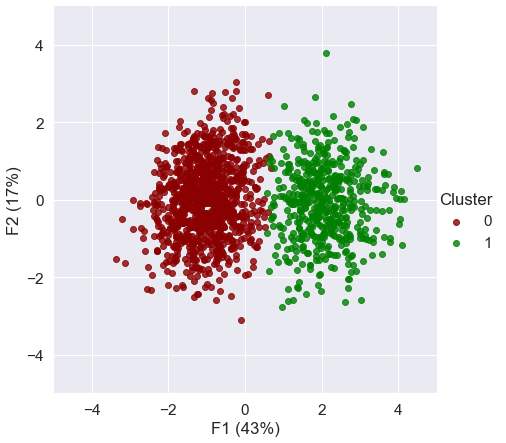

In [259]:
g = sns.lmplot('F1',
               'F2',
               hue='Cluster',data=kmeans_df,
               fit_reg=False,
               scatter=True,palette=palette,
               height=6)
plt.xlabel('F1 ({}%)'.format(
    round(100*pca.explained_variance_ratio_[0]) ,2))
plt.ylabel('F2 ({}%)'.format(
    round(100*pca.explained_variance_ratio_[1]) ,2))
plt.xlim([-5,5])
plt.ylim([-5,5])

plt.show()

La methode des k-moyenne et son clustering a permi de mieux reclasser les vrais et faux billets. Nous obtenons une projection plus "épurée" qui permet de visualiser les clusters sur les axes. Le cluster 1 (vert) represente les vrais billets tandis que le cluster 0 represente les faux (rouge).

In [260]:
kmeans_df.drop(columns=['F1','F2','F3' ,'F4', 'F5' ,'F6'], inplace=True)
kmeans_df['is_genuine'].replace([False, True],[1,0], inplace=True)
kmeans_df

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,Cluster
0,171.810,104.860,104.950,4.520,2.890,112.830,0,1
1,171.460,103.360,103.660,3.770,2.990,113.090,0,0
2,172.690,104.480,103.500,4.400,2.940,113.160,0,0
3,171.360,103.910,103.940,3.620,3.010,113.510,0,0
4,171.730,104.280,103.460,4.040,3.480,112.540,0,0
...,...,...,...,...,...,...,...,...
1303,172.170,104.490,103.760,5.048,2.930,111.210,1,1
1315,172.080,104.150,104.170,4.779,3.400,112.290,1,1
1347,171.720,104.460,104.120,5.727,3.610,110.310,1,1
1435,172.660,104.330,104.410,5.186,3.560,111.470,1,1


In [261]:
vrais = kmeans_df.is_genuine
pred = kmeans.labels_

In [262]:
mx_conf = pd.crosstab(vrais, pred)


**La performance d’un algorithme de Machine Learning est directement liée à sa capacité à prédire un résultat. Lorsque l’on cherche à comparer les résultats d’un algorithme à la réalité, on utilise une matrice de confusion.
Dans les problèmes de classification, il prédit des résultats que l’on doit comparer à la réalité pour mesurer son degré de performance. On utilise généralement la matrice de confusion.
Elle mettra non seulement en valeur les prédictions correctes et incorrectes mais nous donnera surtout un indice sur le type d’erreurs commises.**
 
 * On classe les résultats en 4 catégories : 

1. True Positive (TP) : la prédiction et la valeur réelle sont positives. 
 

2. True Negative (TN) : la prédiction et la valeur réelle sont négatives. 


3. False Positive (FP) : la prédiction est positive alors que la valeur réelle est négative. 


4. False Negative (FN) : la prédiction est négative alors que la valeur réelle est négative. 

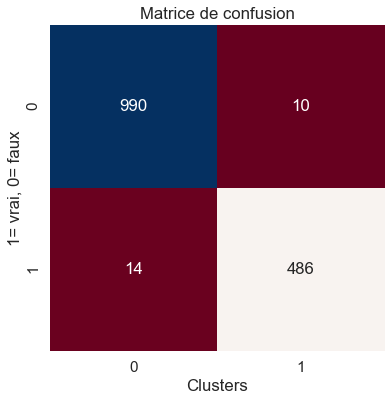

In [263]:
sns.set(rc={'figure.figsize': (6, 6)}, font_scale=1.4)
sns.heatmap(mx_conf, annot = True, fmt='', cmap='RdBu', cbar=False)

plt.title('Matrice de confusion')
plt.xlabel('Clusters')
plt.ylabel('1= vrai, 0= faux')
plt.show()

* Vrais positifs : 990
* Vrais négatifs : 486
*  Faux positifs : 14
* Faux négatifs : 10

In [264]:
print(classification_report(vrais, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.97      0.98       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



* Précision : Elle permet de connaître le nombre de prédictions positifs bien effectuées (sans comptabiliser les oublis)
* Recall : permet de savoir le pourcentage de positifs bien prédit par notre modèle sans erreur.
* F1 Score :  permet d’effectuer une bonne évaluation **globale** de la performance de notre modèle.

In [265]:
accuracy = accuracy_score(vrais, pred)
print("{}% de précision".format( 100*(round(accuracy, 4))))

98.4% de précision


## Il semblerait que la prédiction par k-moyenne a été efficace dans son ensemble. Voyons si nous pouvons encore améliorer notre modèle avec une approche par regression logisitique.


In [266]:
X = billets_final.drop(['is_genuine'], axis=1)
y = billets_final['is_genuine']

In [267]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size=0.2, random_state = 5) 

#Diviser les données en jeu d'entraînement et jeu de test 


In [268]:
X_train1

,diagonal,height_left,height_right,margin_low,margin_up,length
108,171.910,104.230,104.140,3.590,3.110,113.420
76,171.650,103.300,103.550,4.140,3.370,112.870
572,171.830,103.800,104.220,4.660,2.760,113.250
11,171.840,104.590,104.000,3.880,3.270,113.080
398,171.870,104.290,103.530,3.910,2.890,112.910
...,...,...,...,...,...,...
1461,171.920,104.660,104.310,5.150,3.330,112.750
1173,172.120,104.380,104.310,4.820,3.180,111.820
1027,171.630,104.020,104.660,6.700,3.280,111.280
210,172.120,103.760,103.660,4.270,2.950,113.400


In [269]:
y_test1

671      True
959      True
843      True
685      True
1219    False
        ...  
629      True
1154    False
200      True
1253    False
315      True
Name: is_genuine, Length: 300, dtype: bool

In [270]:
log = LogisticRegression()
log.fit(X_train1, y_train1)

LogisticRegression()

In [271]:
y_pred = log.predict(X_test1)


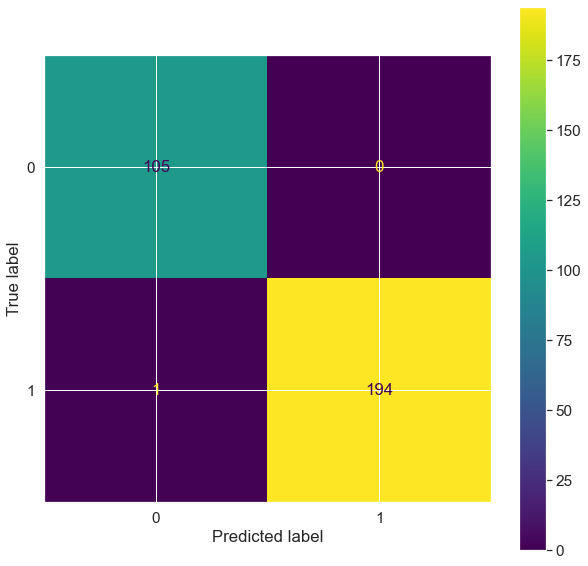

In [272]:
#Matrice de confusion pour la regression logistique

clf = SVC(random_state=0)
clf.fit(X_train1, y_train1)
conf_mx = confusion_matrix(y_test1, y_pred)
cmp = ConfusionMatrixDisplay(conf_mx)
figure,ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

* Vrais positifs : 194
* Vrais négatifs : 105
* Faux positifs : 0
* Faux négatifs : 1

In [273]:
recall_log_vrai = 194/(194+1)
round((recall_log_vrai),4)

print('recall vrais billet à 0,99 et recall faux billets à 1')

recall vrais billet à 0,99 et recall faux billets à 1


In [274]:
accuracy = accuracy_score(y_test1, y_pred)
"{}% de précision".format( 100*(round(accuracy, 4)))

'99.67% de précision'

In [275]:
#R2 
entrainement_eval = log.score(X_train1,y_train1)
test_eval = log.score(X_test1,y_test1)

print('R2 du jeu d entrainement :', entrainement_eval)
print('R2 du jeu de test:', round((test_eval),4))


R2 du jeu d entrainement : 0.9875
R2 du jeu de test: 0.9967


## *Resumé* 
### Performance globale :
### K-means : 98% de prédiction , recall : 98%
### Regression logistique : >99% de prédiction recall : >99,5%

**Nous obtenons donc des résultats plus interressants avec la regression logistique. Au vu de la taille du dataset, il s'avère être malgré tout plus légitime d'ameliorer le modèle avec la regression logistique. De plus, N'oublions pas que nous parlons de billets de banque ; la tolerance zéro est indispensable.**

**Mettons en place (sans plus tarder) notre algorithme de prédiction, puis testons le sur le deuxième jeu de données fournies.**

In [276]:
#importation deu second jeu de données ne comprenant pas les informations sur l'authenticité. 
#Nous avons à la place leur ID de billet.

billets_prod = pd.read_csv("billets_production.csv", sep=',' , index_col=False, header=0)

In [277]:
billets_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.760,104.010,103.540,5.210,3.300,111.420,A_1
1,171.870,104.170,104.130,6.000,3.310,112.090,A_2
2,172.000,104.580,104.290,4.990,3.390,111.570,A_3
3,172.490,104.550,104.340,4.440,3.030,113.200,A_4
4,171.650,103.630,103.560,3.770,3.160,113.330,A_5


In [278]:
#pas de valeurs nulles.
#5 billets à analyser.
billets_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 408.0+ bytes


In [279]:
#prédiction basée sur la regression logistique

y_pred2 = pd.DataFrame(log.predict(billets_prod.set_index('id')))
y_pred2.rename(columns = {'0':'Prédiction'}, inplace = True)
y_pred2['probabilité_vrai'] = log.predict_proba(billets_prod.loc[ : , billets_prod.columns!='id'])[:,1]
y_pred2

,0,probabilité_vrai
0,False,0.005
1,False,0.001
2,False,0.001
3,True,0.917
4,True,1.000


In [280]:
#concatenation du dataset billets_production avec les resultats.

billets_prod['Prédiction'] = y_pred2[0]
billets_prod['Probabilité_vrai (%)'] = 100*(y_pred2["probabilité_vrai"])
billets_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prédiction,Probabilité_vrai (%)
0,171.760,104.010,103.540,5.210,3.300,111.420,A_1,False,0.515
1,171.870,104.170,104.130,6.000,3.310,112.090,A_2,False,0.097
2,172.000,104.580,104.290,4.990,3.390,111.570,A_3,False,0.142
3,172.490,104.550,104.340,4.440,3.030,113.200,A_4,True,91.735
4,171.650,103.630,103.560,3.770,3.160,113.330,A_5,True,99.960


In [281]:
#création de l'algorithme de prédiction sur l'authenticité des billets de banque de l'ONCFM.

def algo_detect(data,  model):
    prediction = pd.DataFrame(log.predict(data.loc[ : , data.columns!='id']))
    prediction['Probabilité_vrai'] = log.predict_proba(data.loc[ : , data.columns!='id'])[:,1]
    data['Prédiction'] = prediction[0]
    data['Probabilité_vrai (%)'] = 100*(prediction["Probabilité_vrai"])
    algo = data[['id','Prédiction','Probabilité_vrai (%)']].set_index("id")
    return algo

In [282]:
data = pd.read_csv("billets_production.csv", sep=',' , index_col=False, header=0)

In [283]:
algo_detect(data, log)

,Prédiction,Probabilité_vrai (%)
id,,
A_1,False,0.515
A_2,False,0.097
A_3,False,0.142
A_4,True,91.735
A_5,True,99.960


In [284]:
# Affichage des resultats:
print("\nAuthenticité des billets:")
for i, k in zip(data["Prédiction"], data["id"]):
    if i == 1:
         print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")


Authenticité des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


![](https://st2.depositphotos.com/5333766/10571/v/950/depositphotos_105719872-stock-illustration-merci-thank-you-in-french.jpg)